In [1]:
import torch
from transformers import ViTMAEModel
from transformers import AutoImageProcessor, ViTMAEModel
from PIL import Image
import requests
import matplotlib.pyplot as plt

model = ViTMAEModel.from_pretrained("facebook/vit-mae-base", attn_implementation="sdpa", torch_dtype=torch.float16)
#print(f"{model.device=}")
model.to("cuda")
print(f"{model.device=}")

#for attrib in dir(model):
#    print(attrib)

/home/max/anaconda3/envs/MVae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model.device=device(type='cuda', index=0)
T_destination
__annotations__
__call__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_apply
_assisted_decoding
_auto_class
_autoset_attn_implementation
_backward_compatibility_gradient_checkpointing
_backward_hooks
_backward_pre_hooks
_beam_search
_buffers
_call_impl
_check_and_enable_flash_attn_2
_check_and_enable_flex_attn
_check_and_enable_sdpa
_compiled_call_impl
_constrained_beam_search
_contrastive_search
_convert_head_mask_to_5d
_copy_lm_head_original_to_resized
_create_repo
_dispatch_accelerate_model
_dola_decoding
_expand_inputs_for_generation
_extract_past_from_model_output
_fix_state_dict_key_on_load
_fix_state_dict_key_on_save
_fix_state_dict_keys_on_load
_fix_state_dict_keys_on_

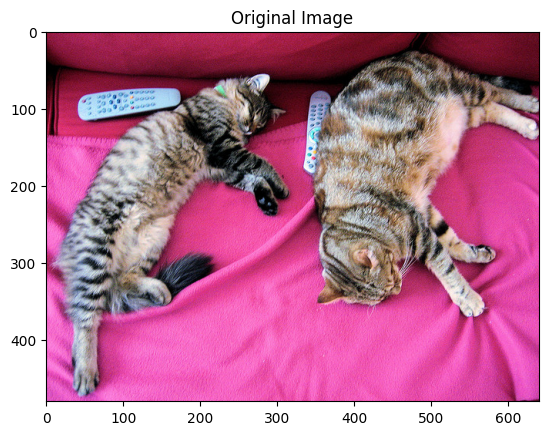

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


inputs.keys()=dict_keys(['pixel_values'])
inputs['pixel_values'].shape=torch.Size([1, 3, 224, 224])


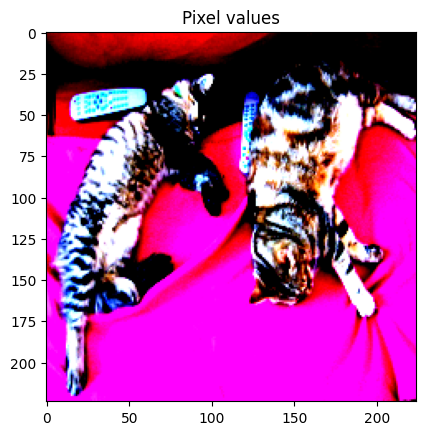

inputs.keys()=dict_keys(['pixel_values'])
inputs['pixel_values'].shape=torch.Size([1, 3, 224, 224])
outputs.keys()=odict_keys(['last_hidden_state', 'mask', 'ids_restore'])
outputs['last_hidden_state'].shape=torch.Size([1, 50, 768])
outputs['mask'].shape=torch.Size([1, 196])
outputs['ids_restore'].shape=torch.Size([1, 196])


In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.title("Original Image")
plt.show()
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")

inputs = image_processor(images=image, return_tensors="pt")
print(f"{inputs.keys()=}")
print(f"{inputs['pixel_values'].shape=}")
inputs_img = inputs["pixel_values"]
plt.imshow(inputs_img[0].permute(1, 2, 0))
plt.title("Pixel values")
plt.show()


print(f"{inputs.keys()=}")
print(f"{inputs['pixel_values'].shape=}")
outputs = model(**inputs)
print(f"{outputs.keys()=}")
print(f"{outputs['last_hidden_state'].shape=}")
print(f"{outputs['mask'].shape=}")
print(f"{outputs['ids_restore'].shape=}")

In [3]:
def reconstruct_image(last_hidden_state, ids_restore, patch_size=16, image_size=224):
    """
    Reconstructs the image from the MAE model's output.
    Args:
        last_hidden_state: The last hidden state output of the model (visible patches).
        ids_restore: The indices to restore the original order of the image patches.
        patch_size: Size of each image patch.
        image_size: Size of the original image (assumes square image).

    Returns:
        Reconstructed image as a NumPy array.
    """
    batch_size, num_visible_patches, embed_dim = last_hidden_state.shape
    num_patches = ids_restore.shape[-1]  # Total number of patches (including masked)
    num_patches_per_dim = image_size // patch_size

    # Create a placeholder tensor for all patches (including masked ones)
    restored_patches = torch.zeros((batch_size, num_patches, embed_dim), device=last_hidden_state.device)

    # Fill in the visible patches in the correct positions using ids_restore
    for i in range(batch_size):
        restored_patches[i].scatter_(dim=0, index=ids_restore[i].unsqueeze(-1).expand(-1, embed_dim), src=last_hidden_state[i])

    # Reshape to (batch_size, num_patches_per_dim, num_patches_per_dim, embed_dim)
    restored_patches = restored_patches.view(
        batch_size, num_patches_per_dim, num_patches_per_dim, embed_dim
    )

    # Convert to (batch_size, embed_dim, num_patches_per_dim, num_patches_per_dim) for image-like format
    restored_patches = restored_patches.permute(0, 3, 1, 2)

    # Upscale the patches to the original image size
    reconstructed_image = torch.nn.functional.interpolate(
        restored_patches, scale_factor=patch_size, mode="nearest"
    )
    return reconstructed_image.squeeze().detach().cpu().numpy()

# Reconstruct the image
reconstructed_image = reconstruct_image(
    outputs["last_hidden_state"], outputs["ids_restore"], patch_size=16, image_size=224
)

# Normalize and display the reconstructed image
reconstructed_image = (reconstructed_image - reconstructed_image.min()) / (
    reconstructed_image.max() - reconstructed_image.min()
)
plt.imshow(reconstructed_image.transpose(1, 2, 0))  # Convert to HWC format for plotting
plt.title("Reconstructed Image")
plt.show()


RuntimeError: Expected index [196, 768] to be smaller than self [196, 768] apart from dimension 0 and to be smaller size than src [50, 768]